In [2]:
import numpy as np
import torchvision
import torch
import torch.nn as nn

from torch.utils.data import DataLoader
from torchvision.models import resnet18, ResNet18_Weights

import tools.KNN as knn
import tools.MLP as mlp
import tools.LogisticRegression as LG
import tools.ImageProcessor as ip
import tools.Criterion as criterion
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_multiclass_roc(predictions, labels, n_classes):
    if isinstance(predictions, torch.Tensor):
        predictions = predictions.cpu().numpy()
    if isinstance(labels, torch.Tensor):
        labels = labels.cpu().numpy()
    labels = labels.copy()
    predictions = predictions.copy()
    # 将标签从1开始转换为从0开始
    labels = labels-1
    predictions = predictions-1
    # 将标签二值化
    labels = label_binarize(labels, classes=np.arange(n_classes))
    predictions = label_binarize(predictions, classes = np.arange(n_classes))
    
    # 计算每个类别的ROC曲线和AUC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels[:, i], predictions[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # 绘制所有类别的ROC曲线
    plt.figure()
    colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive']
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i+1} (area = {roc_auc[i]:0.2f})')  # 类别标签从1开始
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
    plt.legend(loc="lower right")
    plt.show()

def plot_roc_mul_for_self_model(predictions, labels, n_classes):
    predictions = predictions+1
    labels = labels+1
    plot_multiclass_roc(predictions, labels, n_classes)

def plot_loss(losses, title, interval = 1000):
    plt.figure()
    plt.plot(np.arange(len(losses)) * interval, losses)
    plt.title(title)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.show()

In [4]:
transform = torchvision.transforms.Compose([
        # transforms.RandomResizedCrop(224, scale=(0.8, 1.2), ratio=(0.9, 1.1)),
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

batch_size = 5

trainset = ip.ImageFolderWithPaths(root='statics/FundusDomainTrain', transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=8)

testset = ip.ImageFolderWithPaths(root='statics/FundusDomainTest', transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [5]:
model = resnet18(weights=ResNet18_Weights.DEFAULT, progress=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, len(trainset.classes))
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
ce = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [7]:
num_epochs = 3
features = []
labels = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    # 收集所有的outputs和labels
    # all_outputs = []
    # all_labels = []
    
    for images, labels, _ in trainloader:
        images, labels = images.to(device), labels.to(device)
        
        # 前向传播，收集输出和标签
        outputs = model(images)
        # all_outputs.append(outputs)
        # all_labels.append(labels)
        loss = ce(outputs, labels)
         # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # 合并所有输出和标签
    # all_outputs = torch.cat(all_outputs)
    # all_labels = torch.cat(all_labels)
    
    # 计算损失    
    running_loss += loss.item()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader)}')
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels, _ in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print(f'Validation Accuracy: {100 * correct / total}%')
    

Epoch [1/3], Loss: 7.661796538837698e-06
Validation Accuracy: 100.0%
Epoch [2/3], Loss: 5.101686997326794e-05
Validation Accuracy: 99.6415770609319%
Epoch [3/3], Loss: 3.7554422522962883e-06
Validation Accuracy: 100.0%


In [8]:
# get all predictinos
predicts = []
labels = []
with torch.no_grad():
    for images, ls, _ in testloader:
        images, ls = images.to(device), ls.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicts.append(predicted)
        labels.append(ls)
predicts = torch.cat(predicts).cpu().numpy()
labels = torch.cat(labels).cpu().numpy()

[0 0 0 0 0 0 0 0 0 0] [0 0 0 0 0 0 0 0 0 0]
(279,)
Accuracy: 100.00%


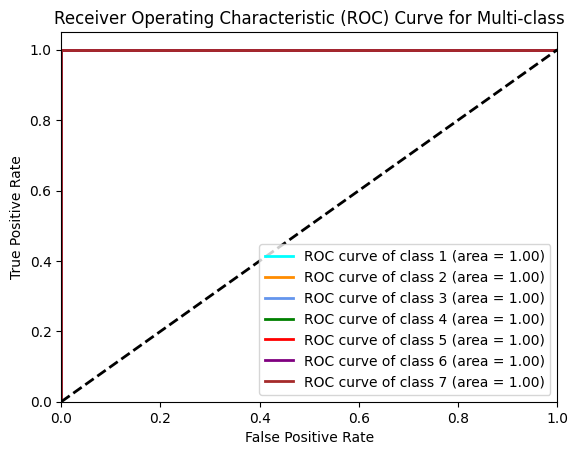

In [11]:
print(predicts[:10], labels[:10])
print(predicts.shape)
criterion.criterion(predicts, labels)
plot_roc_mul_for_self_model(predicts, labels, 7)